# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

## steps
Camera calibration

Distortion correction

Color/gradient threshold

Perspective transform

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
# %matplotlib inline

## 1. Camera calibration

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
# %matplotlib qt

h_points = 9
v_points = 6
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((h_points * v_points, 3), np.float32)
objp[:,:2] = np.mgrid[0:h_points, 0:v_points].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (h_points, v_points), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (h_points, v_points), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
#         cv2.imshow('img', img)
#         cv2.waitKey(500)

# cv2.destroyAllWindows()

In [3]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_size = (img.shape[1], img.shape[0])

In [4]:
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

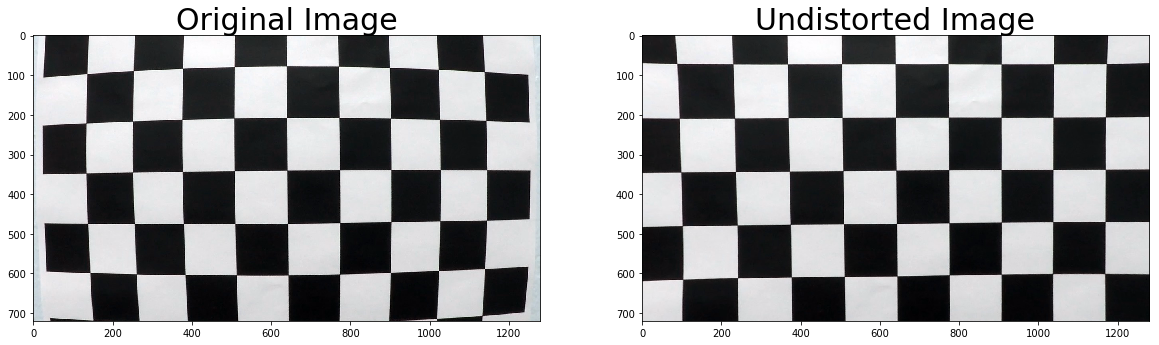

In [5]:

dst = cv2.undistort(img, mtx, dist, None, mtx)
# cv2.imwrite('camera_cal/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
# pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [6]:
IMAGE_SHAPE = (720, 1280, 3)

In [7]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension


In [8]:
src = np.float32([[263, 680],[1044, 680], [582, 460], [699, 460]])
dst = np.float32([[260, 720],[1040, 720], [260, 0], [1040,0]])
    
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

In [9]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        
    def get_plot_x(self, ploty):
        # Generate x and y values for plotting
#         ploty = np.linspace(0, IMAGE_SHAPE[0]-1, IMAGE_SHAPE[0] )
        fitx = self.best_fit[0]*ploty**2 + self.best_fit[1]*ploty + self.best_fit[2]
        return fitx
    def fit(self):
        # Fit a second order polynomial to each
        self.current_fit = np.polyfit(self.ally, self.allx, 2)

        if self.best_fit is None:
            self.best_fit = self.current_fit
        else:
            self.best_fit = 1/2*(self.best_fit + self.current_fit)
        
    def calc_curvature(self, unit="m"):
        # Define y-value where we want radius of curvature
        # I'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(self.ally)

        if unit == "m":
            # Fit new polynomials to x,y in world space
            fit_m = np.polyfit(self.ally*ym_per_pix, self.allx*xm_per_pix, 2)
            # Calculate the new radii of curvature# Define a class to receive the characteristics of each line detection
            curv = ((1 + (2*fit_m[0]*y_eval*ym_per_pix + fit_m[1])**2)**1.5) / np.absolute(2*fit_m[0])
            # Now our radius of curvature is in meters
        else:
            # pixel unit
            curv = ((1 + (2*self.current_fit[0]*y_eval + self.current_fit[1])**2)**1.5) / np.absolute(2*self.current_fit[0])

        self.radius_of_curvature = curv
        return curv

    def calc_pos(self):
        y_eval = np.max(self.ally)
        x = self.get_plot_x(y_eval)
        self.line_base_pos = (x - IMAGE_SHAPE[1]/2)*xm_per_pix
        return self.line_base_pos

    def update(self):
        self.fit()
        self.calc_curvature()
        self.calc_pos()
        
#     def draw(self, image, ploty, color):
#         fitx = self.get_plot_x(ploty)
#         pts = np.array([np.transpose(np.vstack([fitx, ploty]))])
#         cv2.polylines(image, pts, False, color)
#         return image


In [10]:
import math

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def color_thresh(img, s_thresh_min = 170, s_thresh_max = 255):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    return s_binary
    
def perspective_transform(img):
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    return warped

def perspective_transform_inv(img):
    source_img = cv2.warpPerspective(img, Minv, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    return source_img

In [11]:
def draw_lane(left, right):
    ploty = np.linspace(0, IMAGE_SHAPE[0]-1, IMAGE_SHAPE[0])
    left_fitx = left.get_plot_x(ploty)
    right_fitx = right.get_plot_x(ploty)
    image = np.zeros(IMAGE_SHAPE).astype(np.uint8)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(image, np.int_([pts]), (0,255, 0))
    
    return image
    

In [12]:

def find_lane_points(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    

    return leftx, lefty, rightx, righty

def find_lane_points_with_prior(binary_warped, left_fit, right_fit, plot_output=False):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
        
    return leftx, lefty, rightx, righty


In [13]:
def calc_off_center(left, right):
    return -(left.line_base_pos + right.line_base_pos)/2

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [14]:
import os
os.listdir("test_images/")

['straight_lines1.jpg',
 'straight_lines2.jpg',
 'test1.jpg',
 'test2.jpg',
 'test3.jpg',
 'test4.jpg',
 'test5.jpg',
 'test6.jpg']

In [28]:
image = mpimg.imread("test_images/straight_lines1.jpg")

In [16]:
# cv2.imwrite('undistort_straight_lines1.png',undistort(image))

In [29]:
result = find_lane(image)

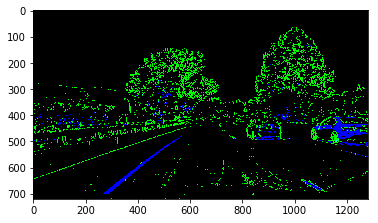

In [26]:
plt.imshow(result[0][0])

In [ ]:
cv2.cvtColor(result[0][-1], cv2.COLOR_RGB2BGR)

In [35]:
cv2.imwrite('./examples/example_output.jpg', cv2.cvtColor(result[0][-1], cv2.COLOR_RGB2BGR))

True

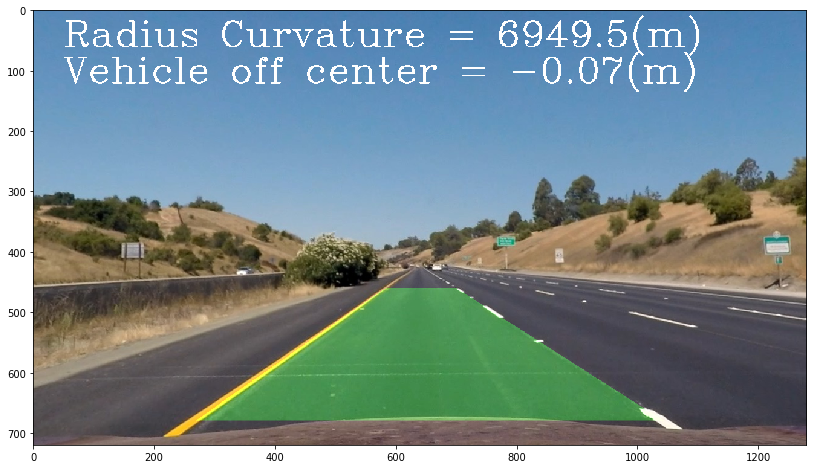

In [34]:
plt.figure(figsize=(16,8))
plt.imshow(result[0][-1])

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [17]:
def find_lane(image, left=None, right=None):
    undist = undistort(image)
    # apply gradient threshold
    grad_binary = abs_sobel_thresh(undist, orient='x', thresh_min=20, thresh_max=255)

    # apply color threshold
    s_binary = color_thresh(undist, s_thresh_min = 180, s_thresh_max = 255)

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(grad_binary)
    combined_binary[(s_binary == 1) | (grad_binary == 1)] = 1
    
    combined_color = np.dstack((np.zeros_like(s_binary), grad_binary, s_binary))
    combined_color[combined_color > 0] = 255
    
    warped_binary = perspective_transform(combined_binary)
    warped = perspective_transform(undist)

    if (left is None) or (right is None):
        left = Line()
        right = Line()
        left.allx, left.ally, right.allx, right.ally = find_lane_points(warped_binary)
    else:
        left.allx, left.ally, right.allx, right.ally = find_lane_points_with_prior(warped_binary, left.best_fit, right.best_fit)
    
    left.update()
    right.update()

    color_line = draw_lane(left, right)
    
    ploty = np.linspace(0, IMAGE_SHAPE[0]-1, IMAGE_SHAPE[0])

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_line, Minv, (image.shape[1], image.shape[0])) 
    
    newwarp = perspective_transform_inv(color_line)
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    curv = (left.radius_of_curvature + right.radius_of_curvature)/2
    font = cv2.FONT_HERSHEY_COMPLEX
    cv2.putText(result,'Radius Curvature = %.1f(m)' % curv,(50,60), font, 2,(255,255,255),2)

    cv2.putText(result,'Vehicle off center = %.2f(m)'% calc_off_center(left, right),(50,120), font, 2,(255,255,255),2)

    return [combined_color, warped, color_line, result], [left, right]
    

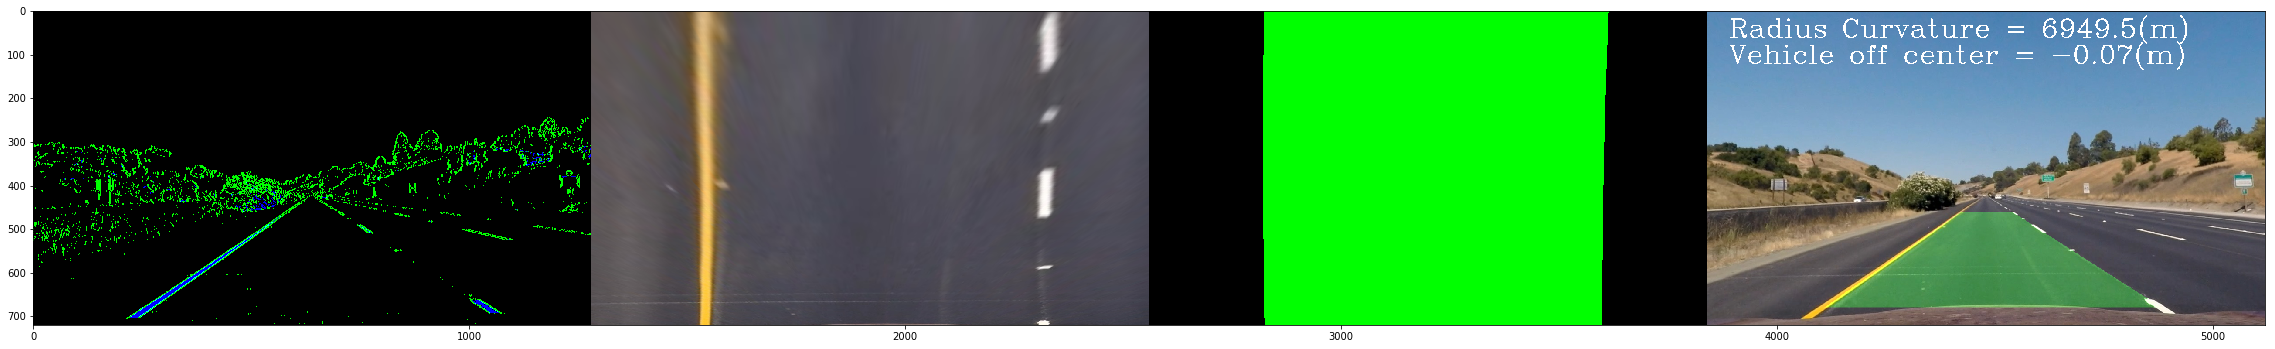

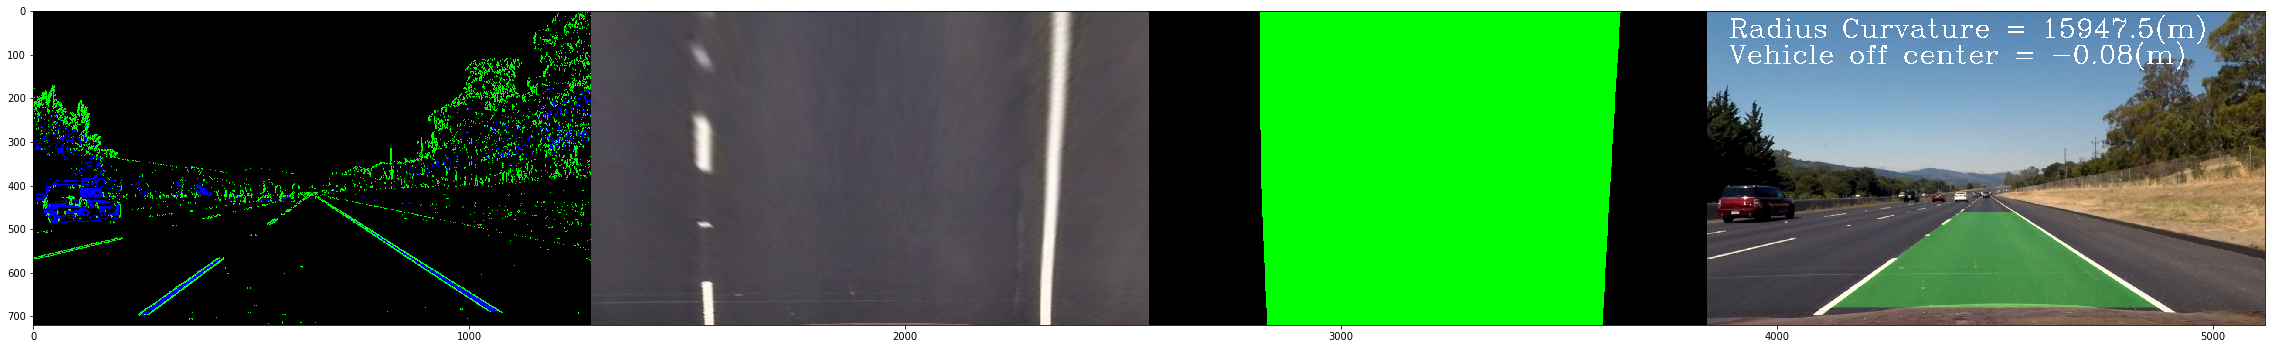

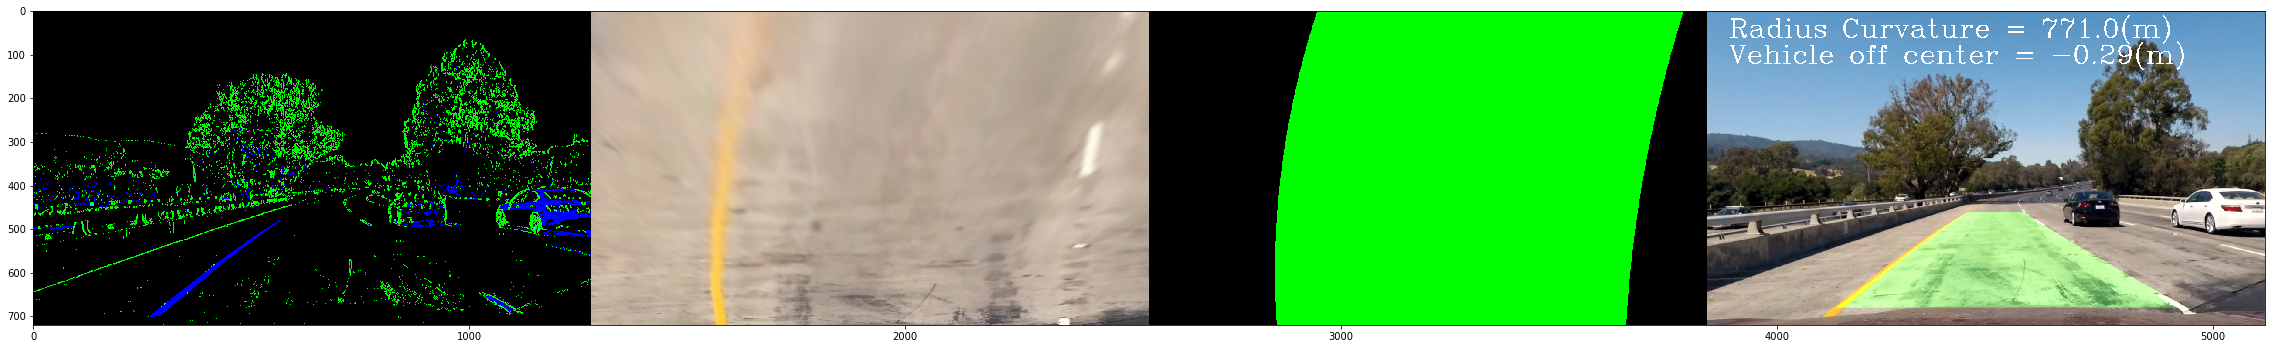

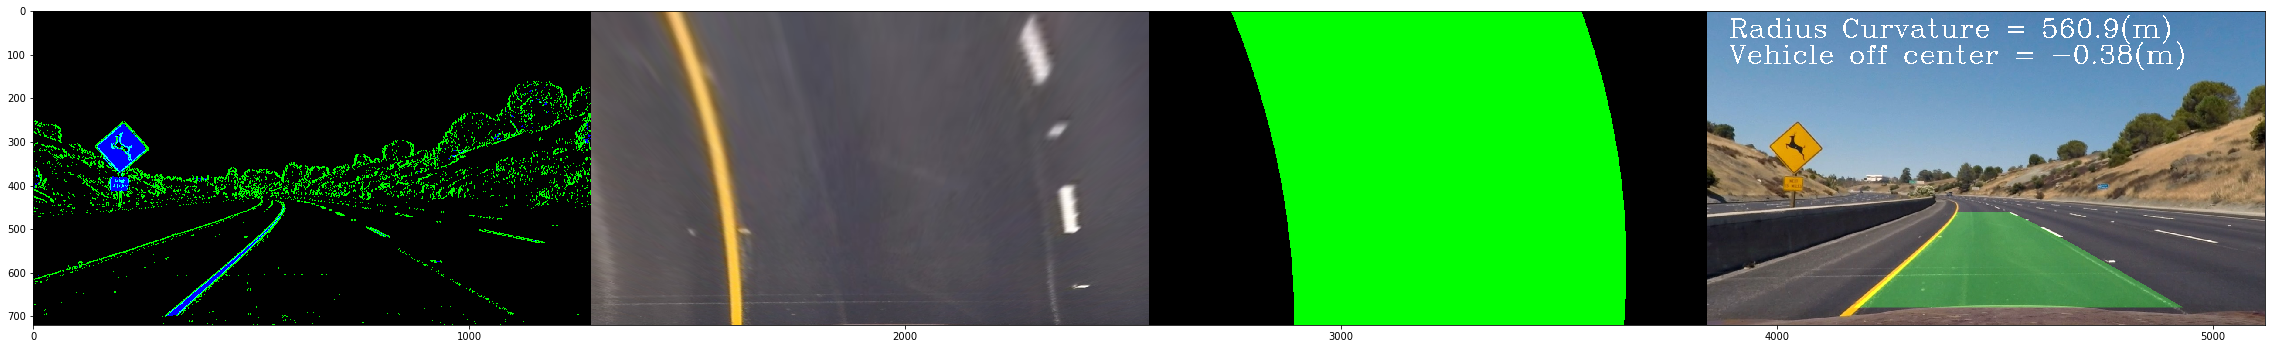

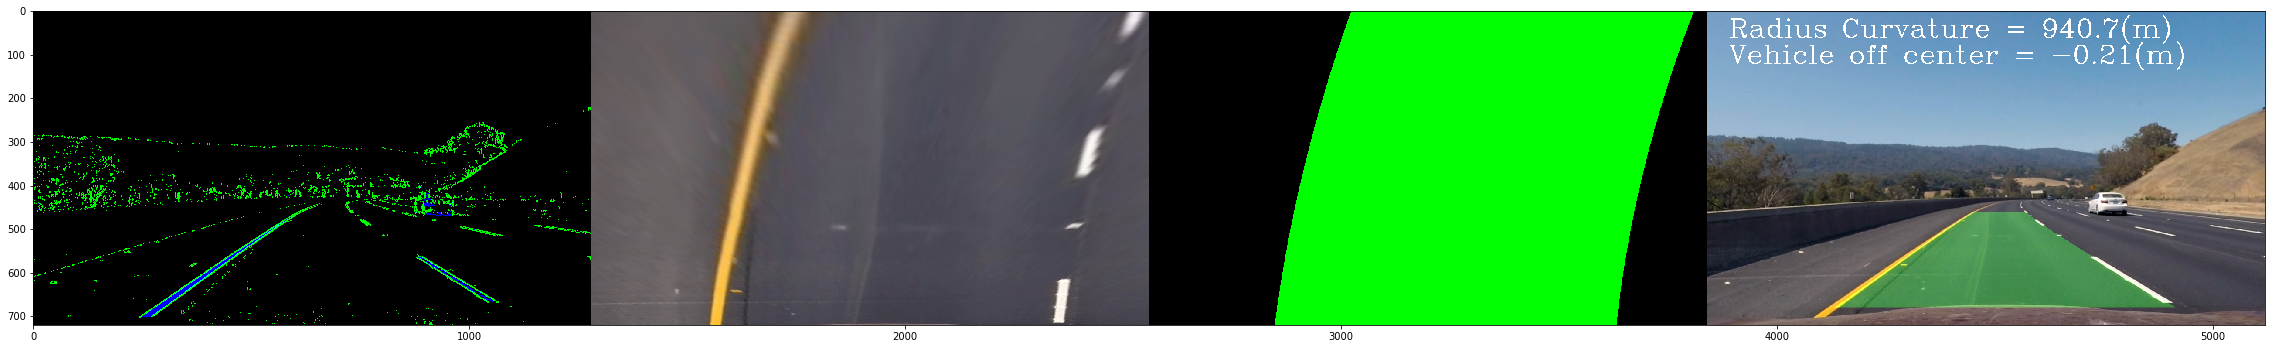

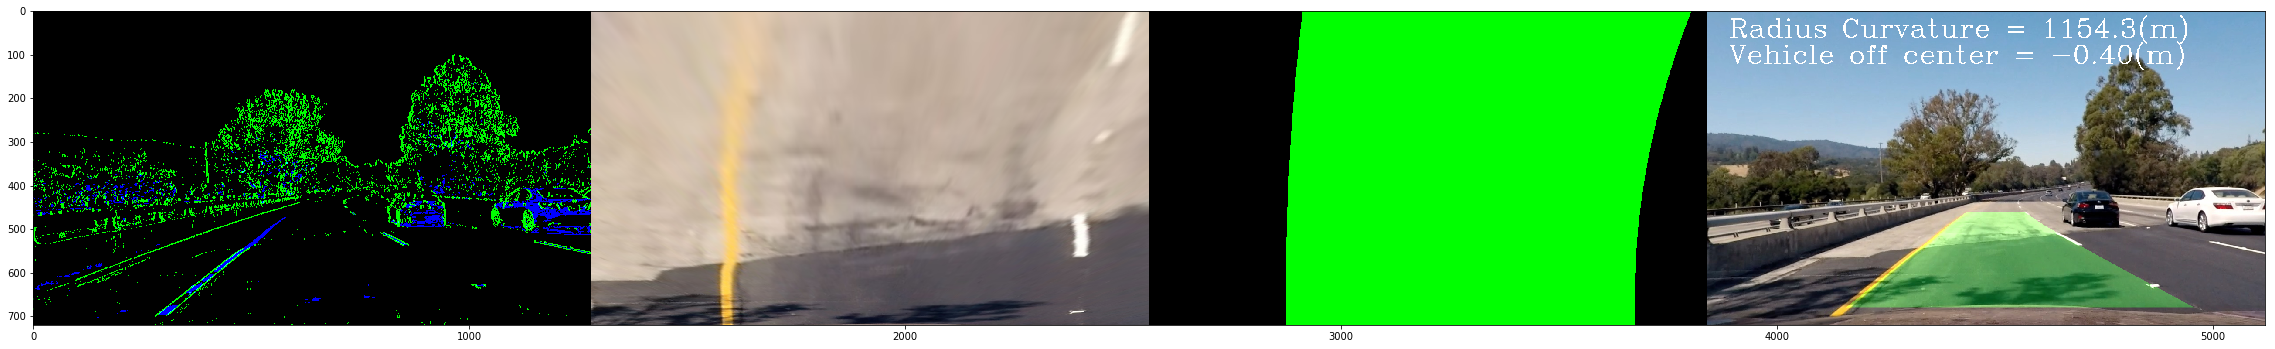

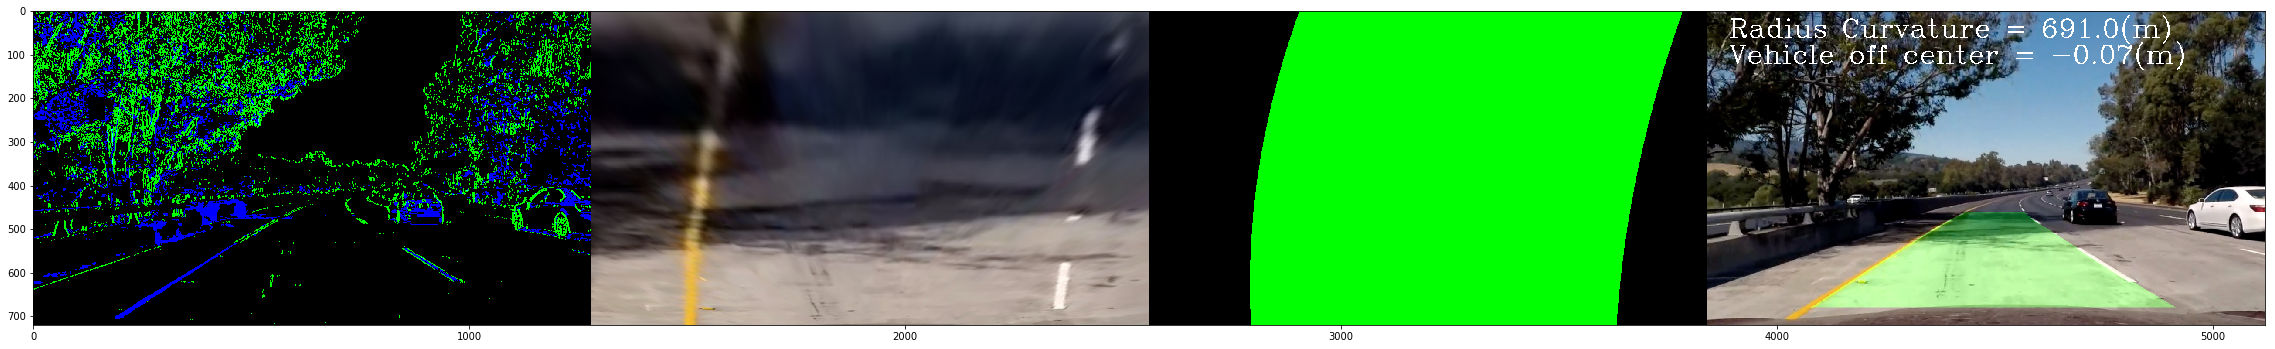

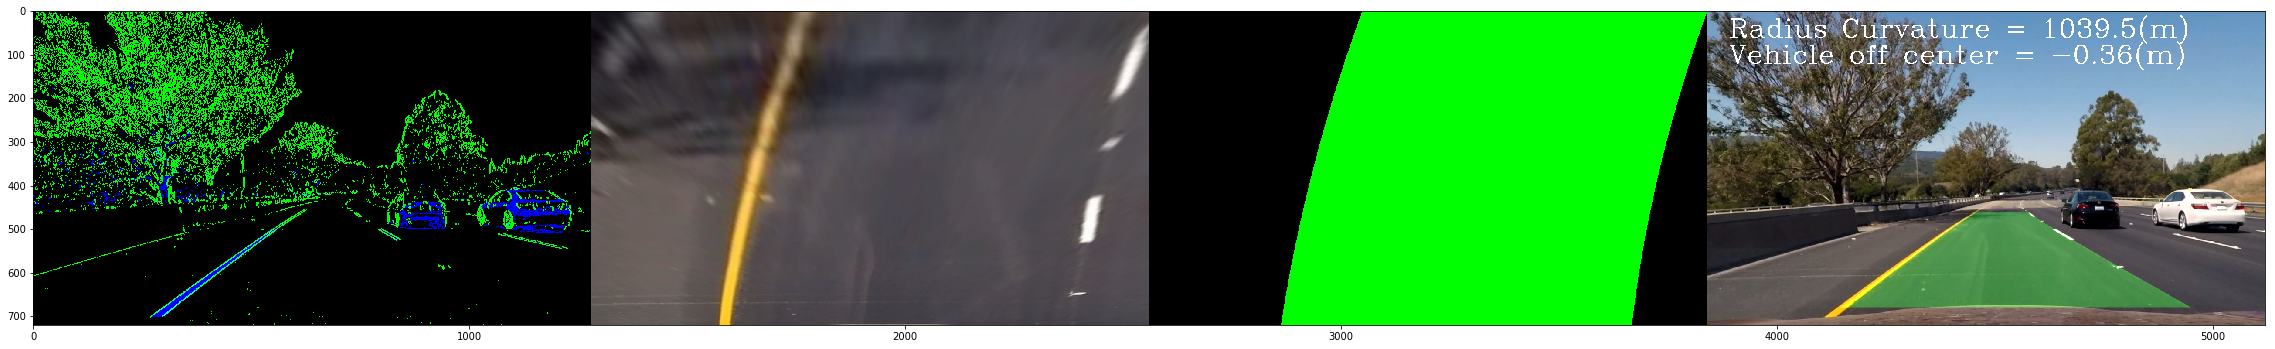

In [18]:
for image_file in os.listdir("test_images/"):
    img = mpimg.imread("test_images/"+image_file)
    
    # show result
    images, lr = find_lane(img)
    result = np.hstack(images)
    plt.figure(figsize=(40,20))
    plt.imshow(result)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [20]:
video_left = None
video_right = None

def process_image(image):
    global video_left, video_right
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    images, lr = find_lane(image, video_left, video_right)
#     result = np.hstack(images)
    result = images[-1]
    video_left = lr[0]
    video_right = lr[1]
    return result

Let's try the one with the solid white lane on the right first ...

In [21]:
white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [02:48<00:00,  7.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 4min 48s, sys: 36.6 s, total: 5min 25s
Wall time: 2min 49s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))